# Managing Azure OpenAI Safety with Configurable Content Filters
## Configuring the filter to be less restrictive for news articles summarization

Azure OpenAI Service offers a content filtering mechanism that operates in tandem with its core models. This system processes both the prompts and completions using a set of classification models designed to identify and mitigate the release of harmful content. It identifies and addresses various categories of potential risks in both input prompts and generated output:

| Category  | Description |
|---|---|
| Hate | The hate category describes language attacks or uses that include pejorative or discriminatory language with reference to a person or identity group on the basis of certain differentiating attributes of these groups including but not limited to race, ethnicity, nationality, gender identity and expression, sexual orientation, religion, immigration status, ability status, personal appearance, and body size. |
| Sexual | The sexual category describes language related to anatomical organs and genitals, romantic relationships, acts portrayed in erotic or affectionate terms, physical sexual acts, including those portrayed as an assault or a forced sexual violent act against one’s will, prostitution, pornography, and abuse. |
| Violence | The violence category describes language related to physical actions intended to hurt, injure, damage, or kill someone or something; describes weapons, etc. |
| Self-Harm | The self-harm category describes language related to physical actions intended to purposely hurt, injure, or damage one’s body, or kill oneself. |

The behavior of this filtering can be influenced by different API configurations and application designs.  
The appropriate degree of filtering is use-case specific. For instance, creating content for young children necessitates stricter settings compared to summarizing news articles. This notebook examines the classification of newspaper articles by the content filtering system and the summaries we aim to produce using Azure OpenAI.
  
<img src="./newspapers.png" alt="drawing"/> 

__In this notebook:__  
1. Download the CNN / DailyMail dataset and prepare a subset for the Content Filter summarization use case.  
2. Summarize news articles with Azure OpenAI and extract Content Filter severity annotations for the articles and generated summaries.  
3. Specify a target configuration for the use case by reviewing the filter impact and border cases of various settings.  
4. Adjust the Azure OpenAI Content Filter settings to the desired configuration to get the final summarization results.

__Please note__ 
- You need to specify your `AZURE_OPENAI_API_KEY`and `AZURE_OPENAI_ENDPOINT` in the environment file `env` file in this folder to execute this notebook.
- You also need a [Kaggle account](https://www.kaggle.com/account/login) to download the dataset that is used in this notebook.


## Setup

In [1]:
# Installs
# %pip install python-dotenv openai==0.28.1 opendatasets tenacity tiktiken

In [1]:
# Imports
import os
import openai
import tiktoken
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
from IPython.display import display, Markdown
import requests
import json
from tenacity import retry, stop_after_attempt, wait_fixed

%config InlineBackend.figure_format = 'retina'

if not load_dotenv('./env'): raise Exception(".env file not found")

openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT") 
openai.api_version = "2023-07-01-preview"
openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")
deployment = "gpt-35-turbo-0613"

bold_start, bold_end = '\033[1m', '\033[0m'  

## Central Variables

In [2]:
sys_prompt = """\
You are a helpful assistant that summarizes news articles based on user input. Read the complete article and then summarize it in your own words."""

sample_size = 300 # number of articles
content_col = 'article' # content column of your dataframe
output_folder = './news-summarization' # intermediate and final results are stored here

os.makedirs(output_folder, exist_ok=True)

## Helper Functions

In [3]:
@retry(stop=stop_after_attempt(3), wait=wait_fixed(20))  # stops after 3 attempts, waits 20 seconds between attempts
def chat_complete(user_prompt: str, deployment=deployment):
    """ Process user_prompt as input for AOAI chat model and returns assistant response, and AOAI content filter annotations for user_prompt and generated response."""

    result = ''
    cf_prompt_results = {}
    cf_completion_results = {}

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": user_prompt},
    ]

    try:
        response = openai.ChatCompletion.create(engine= deployment, messages= messages, temperature= 0)
        
        cf_prompt_results = response['prompt_filter_results'][0]['content_filter_results']
        cf_completion_results = response['choices'][0]['content_filter_results']

        if response['choices'][0]['finish_reason'] == "content_filter":
            # Trigger on completion
            result = '(Completion blocked by Content Filter)'
        else:
            # No trigger (content ok)
            result = response['choices'][0]['message']['content']

    except openai.error.InvalidRequestError as e:

        if e.error.code == "content_filter" and e.error.innererror:
            # Trigger on prompt
            cf_prompt_results = e.error.innererror.content_filter_result

            cf_completion_results = {"hate": {"filtered": None, "severity": "n/a"}, 
                                     "self_harm": {"filtered": None, "severity": "n/a"},
                                     "sexual": {"filtered": None, "severity": "n/a"},
                                     "violence": {"filtered": None, "severity": "n/a"}}

            result = '(Input blocked by Content Filter)'
    
    return result, cf_prompt_results, cf_completion_results


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def calculate_cumulative_value(column, threshold):
    if threshold == 'off':
        cumulative_value = column.sum()  # Sum all categories when threshold is 'off'
    else:
        severity_order = ['safe', 'low', 'medium', 'high']
        threshold_index = severity_order.index(threshold)
        allowed_severities = severity_order[:threshold_index]
        cumulative_value = column[allowed_severities].sum()
    return cumulative_value

def show_statistics(value_counts_df, filter_threshold):
    """ Plot identified Content Filter severity levels and user filter threshold as stacked barcharts. """
    ordered_index = ['safe', 'low', 'medium', 'high']
    value_counts_df = value_counts_df.reindex(ordered_index)

    value_counts_df = value_counts_df.fillna(0.0)

    colors = ['#28a745', '#74d680', '#ff9f43', '#ff6f61']

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.set_title('Content Filter Severity Levels on the Dataset \n Red border shows content that is filtered in this configuration', fontsize=16)

    value_counts_df.T.plot(kind='barh', stacked=True, ax=ax, color=colors)

    for rect, label in zip(ax.patches, value_counts_df.values.flatten()):
        if label != 0:
            width = rect.get_width()
            ax.text(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2, label,
                    ha='center', va='center')

    for idx, col in enumerate(value_counts_df.columns):
        threshold_value = filter_threshold[col]
        cumulative_value = calculate_cumulative_value(value_counts_df[col], threshold_value)
        ax.vlines(cumulative_value, idx-0.4, idx+0.4, colors='red')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title='Severity', loc='lower left')
    ax.set_xlabel('Documents')

    plt.tight_layout()

    plt.show()

def review_boundary_examples(df, categories):
    """ Show one example at current threshold (acceptable) and another one at the next highest severity (not acceptable). """

    severities = ['safe', 'low', 'medium', 'high', 'off']    

    for category in categories:

        display(Markdown(f'### {category.upper()}'))

        threshold = filter_threshold[category]

        threshold_idx = severities.index(threshold)

        ok_at_threshold = df[df[category] == severities[threshold_idx-1]]
        filtered = df[df[category] == severities[threshold_idx]]

        print(f'Example document classified as {bold_start}{severities[threshold_idx-1].upper()} severity which is considered ACCEPTABLE{bold_end} in the simulated configuration:\n')

        if len(ok_at_threshold) > 0:
            print(ok_at_threshold.iloc[0][content_col])

        else:
            print('(no matching document found)')

        if threshold != 'off':
            print(f'\nExample document classified as {bold_start}{threshold.upper()} severity which is considered NOT ACCEPTABLE{bold_end} in the simulated configuration:\n')

            if len(filtered) > 0:
                print(filtered.iloc[0][content_col])
            else:
                print('(no matching document found)')
        else:
            print('(no matching document found)')

def plot_token_counts(df, max_tokens=4000):
    plt.figure(figsize=(10, 6))
    plt.hist(df['tokens'], bins=50, alpha=0.5, color='g', label='Token Counts')
    plt.axvline(x=max_tokens, color='r', linestyle='--', label=f'Max Tokens = {max_tokens}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title('Distribution of Document Length in Tokens')
    plt.grid(True)
    plt.show()

## Generate Sample based on the News Dataset from Kaggle
We are using the [CNN/DailyMail Dataset](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail) in this notebook. It comprises over 300,000  news articles penned by reporters from CNN and the Daily Mail, all in English. Initially developed for machine reading comprehension and abstractive question answering, it has evolved to facilitate both extractive and abstractive summarization in its latest version.

We will download the dataset from the Kaggle website. You need to create a Kaggle account and have your username and key ready when running the next cell. For the purpose of this demonstration, we only use a sample of 300 shorter articles. Feel free to adjust the `sample_size` if you want to reduce or increase the sample.

In [4]:
dataset_path = './newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'

if not os.path.exists(dataset_path):
    print(f"The file '{dataset_path}' does not exist. Downloading from Kaggle. Please provide your Kaggle username and key in the dialog.")
    od.download('https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail')
else:
    print(f"Found existing file '{dataset_path}'.")

Found existing file './newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'.


In [5]:
df = pd.read_csv(dataset_path)
# remove original article id and summary for simplicity
df = df.drop(columns=['id', 'highlights'])

# calculate article length in tokens
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

df['tokens'] = df[content_col].apply(lambda x: num_tokens_from_string(x, encoding_name=encoding.name))

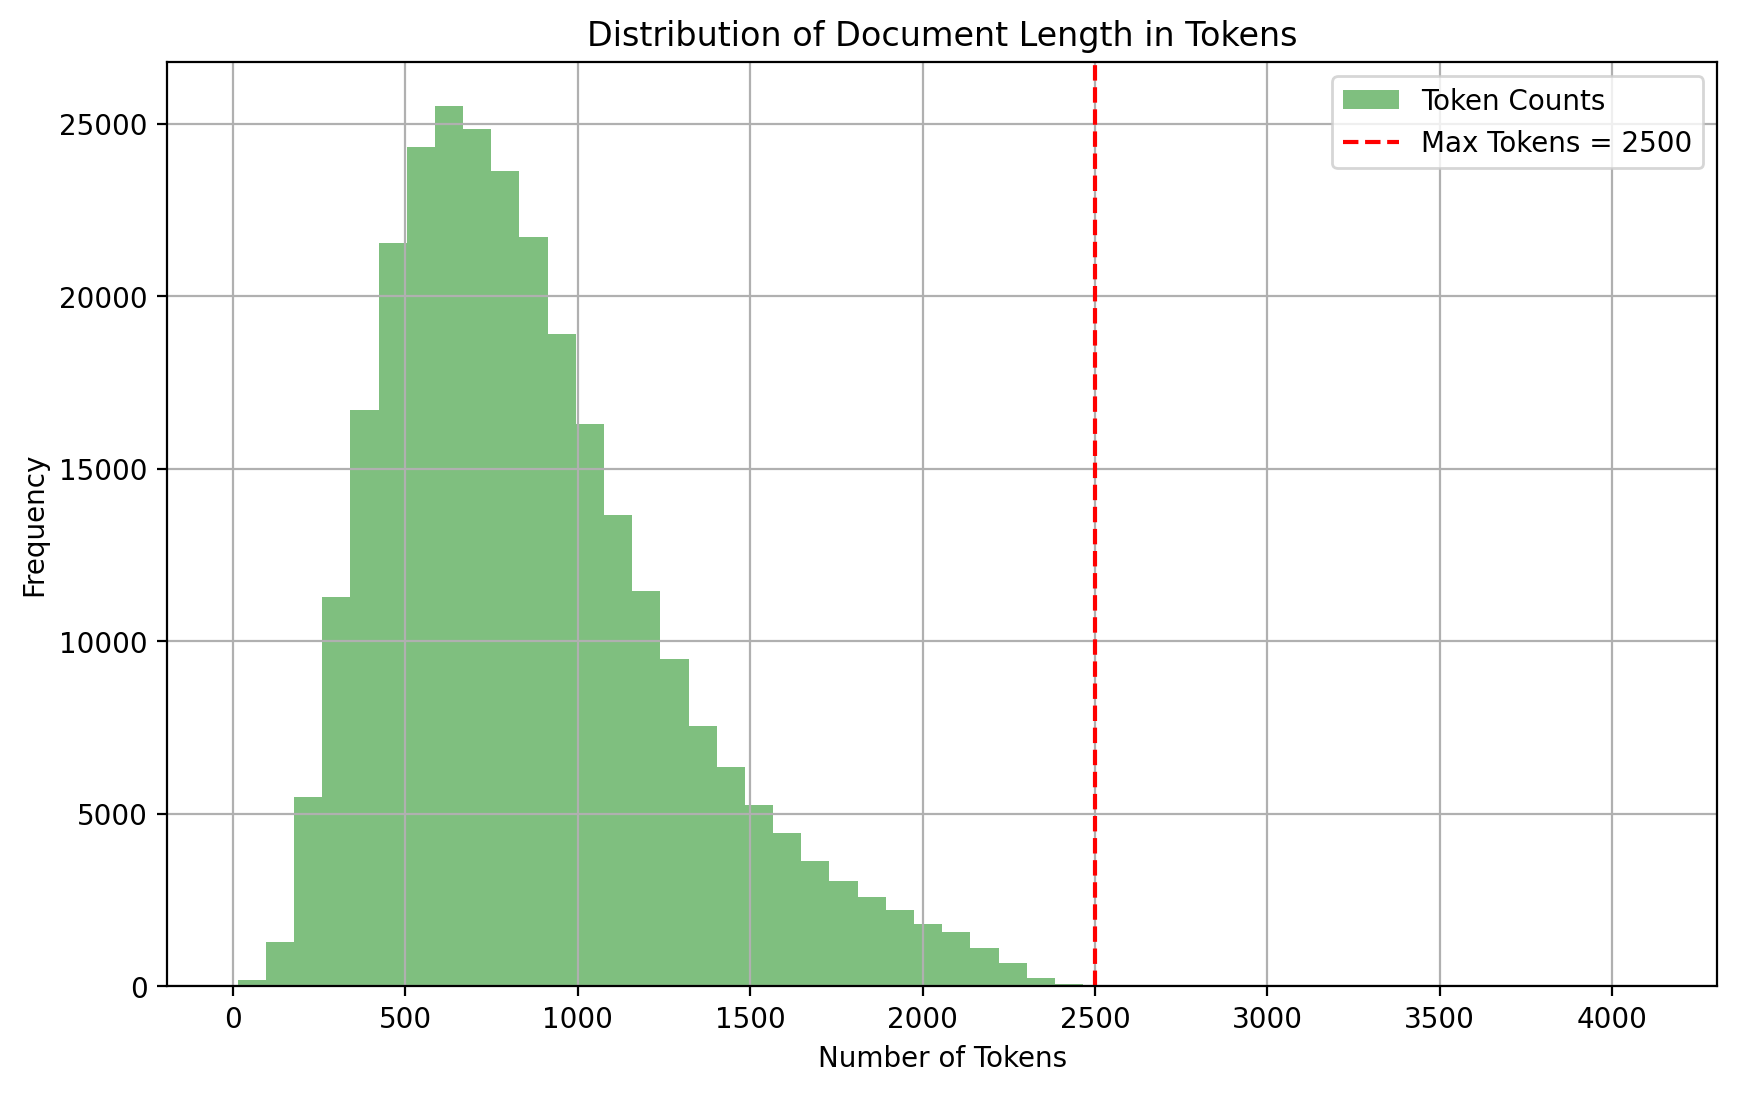

In [6]:
max_input_tokens = 2500 # gpt-3.5-turbo has maximum size of 4097 tokens. Reserving 1500 tokens (approx. 6000 characters) for the model output.

plot_token_counts(df, max_tokens=max_input_tokens)

In [7]:
# drop articles above token limit
df = df[df['tokens'] < max_input_tokens]

# take sample with preference for shorter articles
df = df.sort_values(by='tokens', ascending=True)
weights = 1 / (df['tokens'] + 1)  # Adding 1 to avoid division by zero
normalized_weights = weights / np.sum(weights)

df_sample = df.sample(n=sample_size, replace=False, weights=normalized_weights, random_state=1)

## Generate Summaries and track Content Severity Annotations



In [8]:
# Add columns for summaries and Content Filer annotations
df_sample['summary'] = ""

prompt_severity_cols = ['prompt-hate', 'prompt-sexual', 'prompt-selfharm', 'prompt-violence']
completion_severity_cols = ['compl-hate', 'compl-sexual', 'compl-selfharm', 'compl-violence']
severity_cols = prompt_severity_cols + completion_severity_cols

df_sample = pd.concat([df_sample, pd.DataFrame(columns=severity_cols)])

display(df_sample.head())

,article,tokens,summary,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
286745,(CNN) -- A South Florida man killed his wife a...,531.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197025,"By . Matt Chorley, Mailonline Political Editor...",816.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137538,"Downton Abbey's famously grim butler, Mr Bates .",13.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86626,Schoolchildren were forced to evacuate a playg...,444.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16827,Gender-neutral bathrooms will now be mandatory...,319.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def process_df_row(row):
    content = row[content_col]
    result, cf_prompt_results, cf_complletion_results = chat_complete(content)
    
    # extract and transform severity values from the cf_prompt_results and cf_complletion_results
    row['prompt-hate'] = cf_prompt_results['hate']['severity']
    row['prompt-sexual'] = cf_prompt_results['sexual']['severity']
    row['prompt-selfharm'] = cf_prompt_results['self_harm']['severity']
    row['prompt-violence'] = cf_prompt_results['violence']['severity']
    
    row['compl-hate'] = cf_complletion_results['hate']['severity']
    row['compl-sexual'] = cf_complletion_results['sexual']['severity']
    row['compl-selfharm'] = cf_complletion_results['self_harm']['severity']
    row['compl-violence'] = cf_complletion_results['violence']['severity']
    
    row['summary'] = result
    
    return row

# Generate summaries for the whole dataframe. 
# NOTE that this operation incurs Azure OpenAI service charges.

df_sample = df_sample.apply(process_df_row, axis=1)

You can comment / uncomment the following commands if you want to save the processed sample with annotations or start from a previously saved version.

In [10]:
annot_sample = os.path.join(output_folder, 'sample-with-annotations.csv')

# Save sample to file
df_sample.to_csv(annot_sample, index=False)

# Reload previous version
df_sample = pd.read_csv(annot_sample)

display(df_sample.head())

,article,tokens,summary,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
0,(CNN) -- A South Florida man killed his wife a...,531.0,(Input blocked by Content Filter),safe,safe,safe,medium,unknown,unknown,unknown,unknown
1,"By . Matt Chorley, Mailonline Political Editor...",816.0,Tourism bosses in Britain are using the birth ...,safe,safe,safe,safe,safe,safe,safe,safe
2,"Downton Abbey's famously grim butler, Mr Bates .",13.0,"Downton Abbey's character Mr. Bates, who is kn...",safe,safe,safe,safe,safe,safe,safe,safe
3,Schoolchildren were forced to evacuate a playg...,444.0,"A school in Watford, Hertfordshire had to evac...",safe,safe,safe,safe,safe,safe,safe,safe
4,Gender-neutral bathrooms will now be mandatory...,319.0,"Starting tomorrow, gender-neutral bathrooms wi...",safe,safe,safe,safe,safe,safe,safe,safe


## Review Severity Annotations
Note that if your content is filtered out due to the prompt (input), then no completions will be provided, and as a result, no corresponding annotations will be generated. In such scenarios, the completion severity categories will be marked as non applicable (n/a).

In [11]:
severities = ['safe', 'low', 'medium', 'high', 'n/a']

# Applying value_counts to each column
value_counts_df = df_sample[severity_cols].apply(lambda col: col.value_counts())

# Reindexing the DataFrame
value_counts_df = value_counts_df.reindex(severities)

# Filling NaN values with 0
value_counts_df = value_counts_df.fillna(0).astype(int)

print('Content severity annotations found in the dataset (prompt) and in the model responses (completions):')
display(value_counts_df)


Content severity annotations found in the dataset (prompt) and in the model responses (completions):


,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
safe,294,296,297,267,277,275,284,258
low,5,4,3,17,7,6,0,16
medium,0,0,0,15,0,1,0,10
high,1,0,0,1,0,2,0,0
unknown,0,0,0,0,16,16,16,16


## Understanding the Impact of Your Content Filter Configuration

You can configure the content filter for user input and model response separately using the following options:

![image-alt-text](./cf-table.png)

Examples:

- Set to low: Filters low, medium and high risk content
- Set to medium: Filters medium and high risk content
- Set to high: Filters high risk content
- Set to off: Switch Content Filter off (approval required)

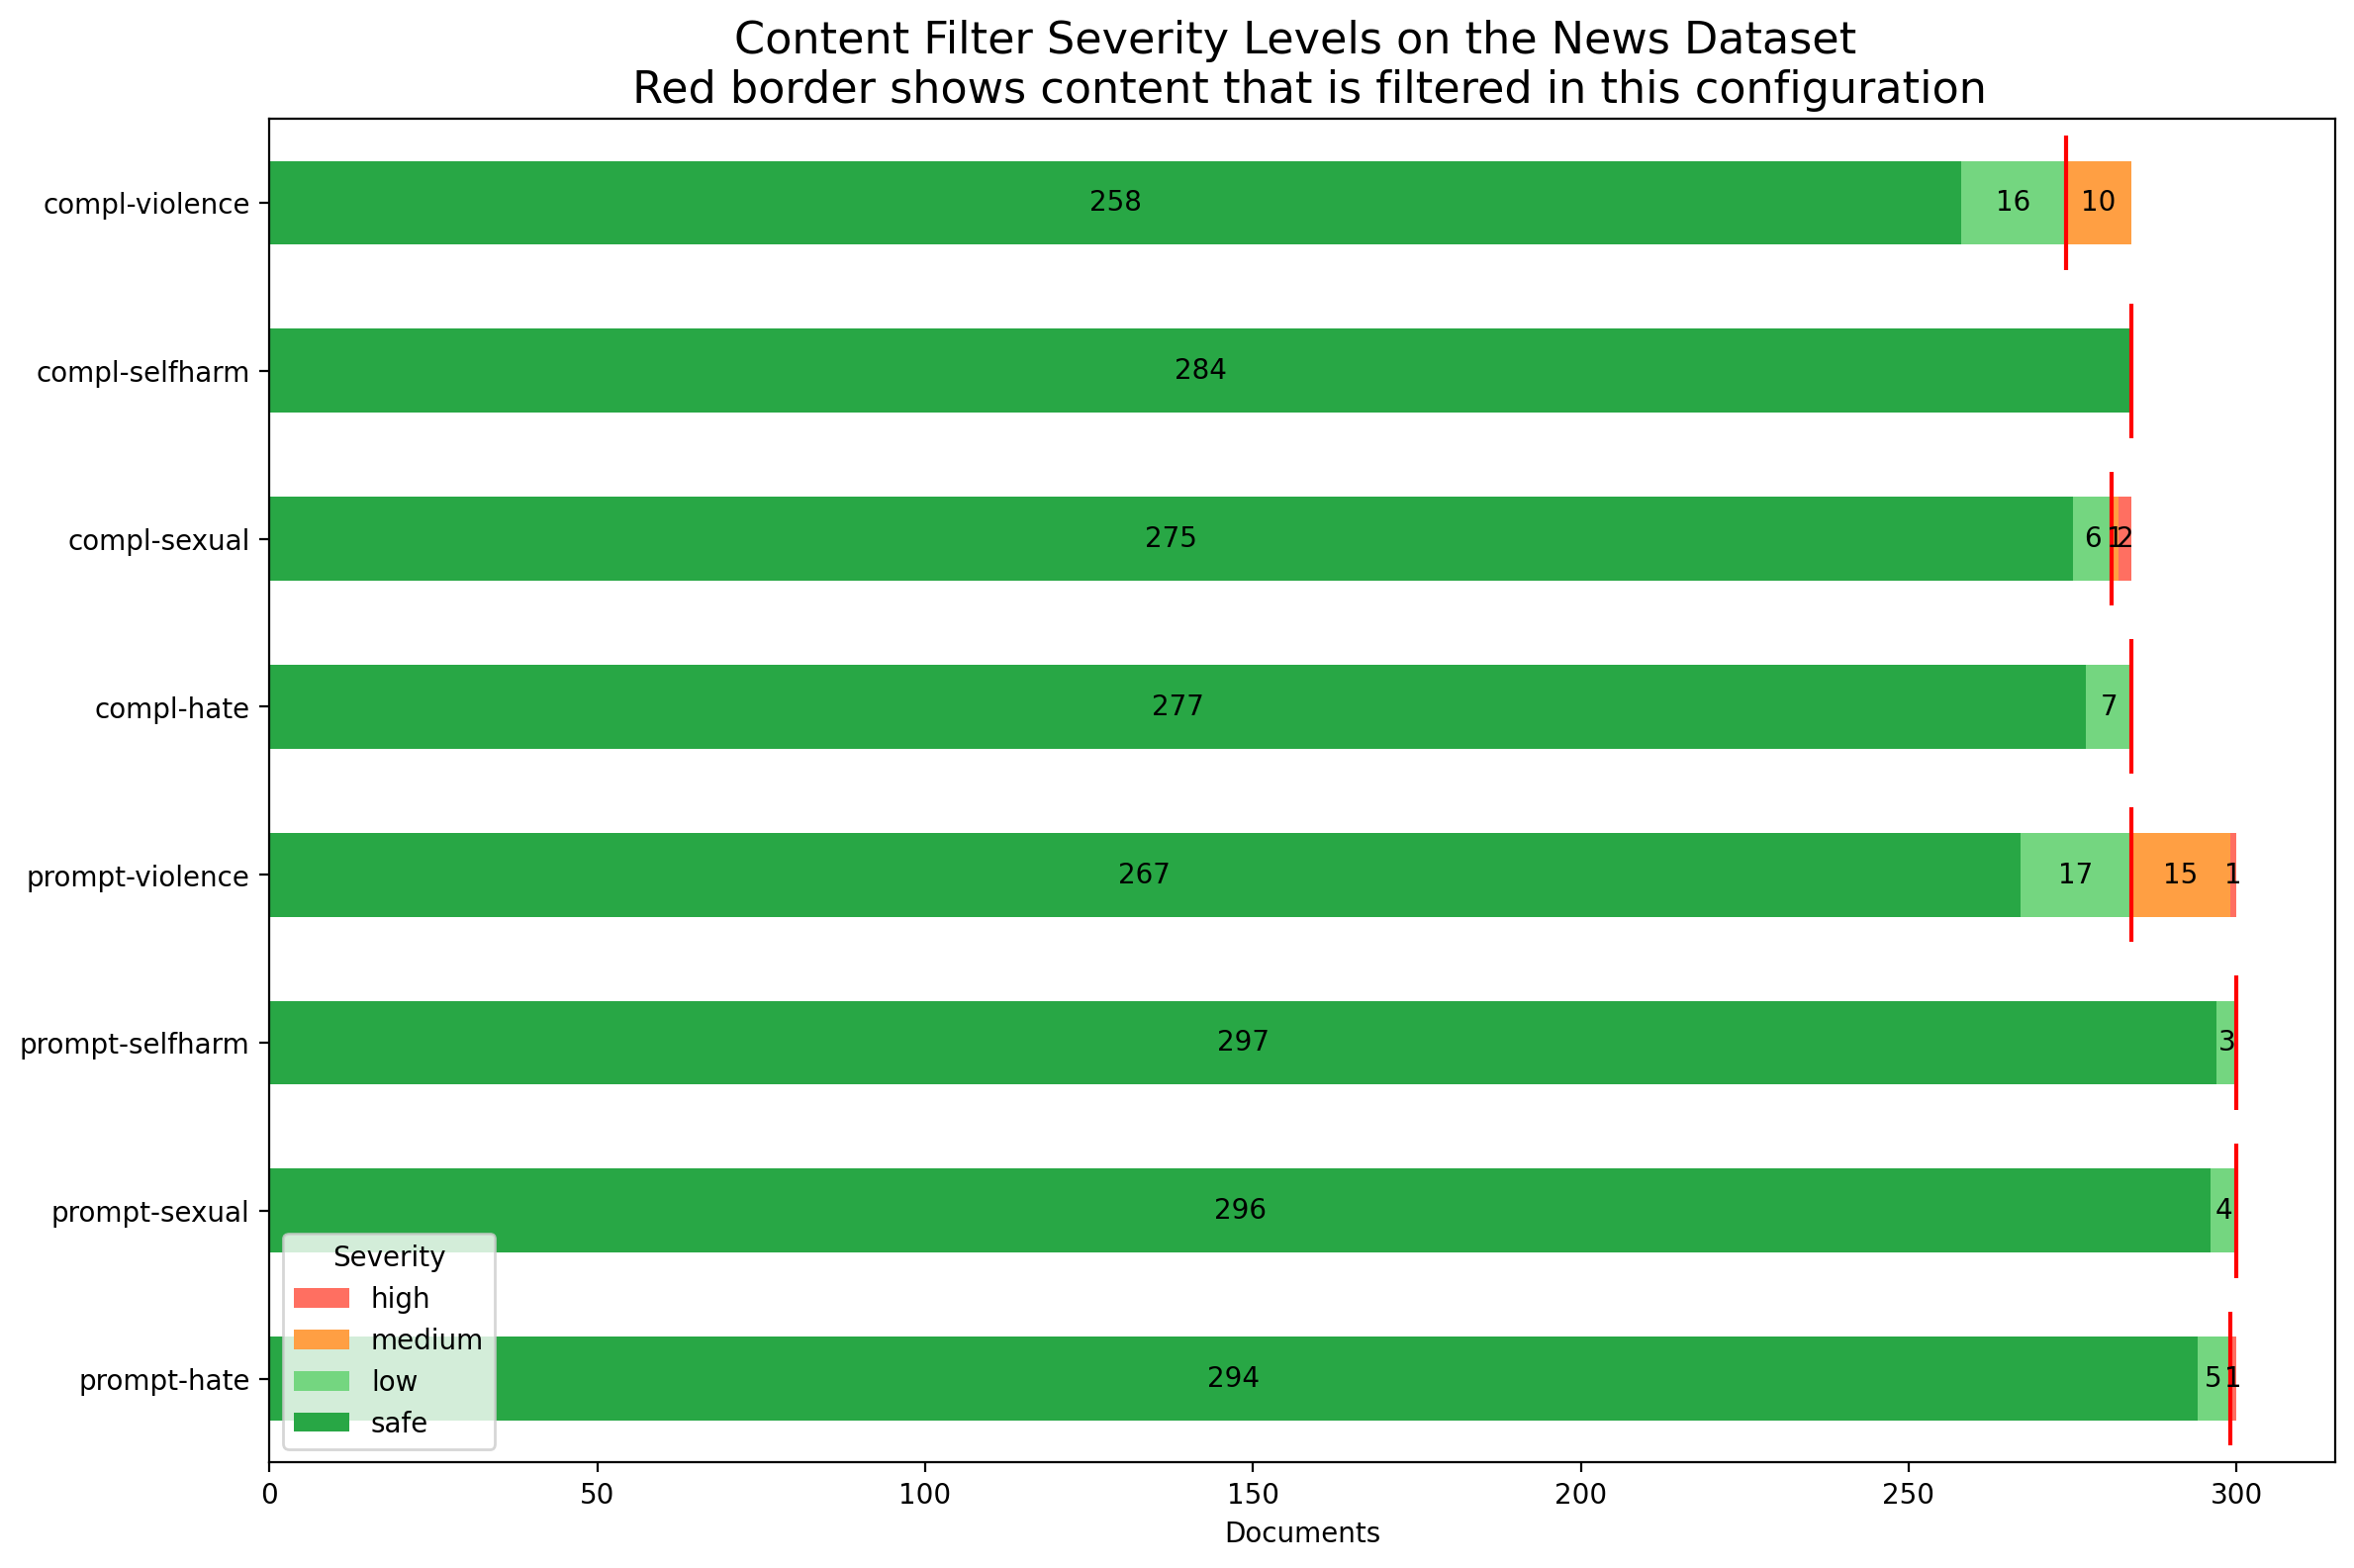

In [12]:
filter_threshold = {
    'prompt-hate' : 'medium',
    'prompt-sexual' : 'medium',
    'prompt-selfharm' : 'medium',
    'prompt-violence' : 'medium',
    'compl-hate' : 'medium',
    'compl-sexual' : 'medium',
    'compl-selfharm' : 'medium',
    'compl-violence' : 'medium',
}

show_statistics(value_counts_df, filter_threshold)

In [13]:
review_boundary_examples(df_sample, prompt_severity_cols)

### PROMPT-HATE

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

By . James  Nye . and Daily Mail Reporter . PUBLISHED: . 00:38 EST, 8 January 2014 . | . UPDATED: . 07:31 EST, 8 January 2014 . Florida Seminole's college footballer Jameis Winston has hit back at criticism over the way he speaks, reminding fans 'We're national champions'. The 20-year-old defended himself on Twitter after A.J. McCarron's mother Dee Dee and his . model girlfriend Katherine Webb sparked a race row when they . appeared to question his ability to speak English. After Winston's post-game interview as his team beat the Auburn Tigers, Ms McCarron had tweeted: 'Am I listening to English?' Victory: Florida Seminoles quarterback Jameis Winston holds the championship trophy after they defeated the Auburn Tigers to win the BCS Championship football game in Pasadena, California January 6, 2014 . Unfazed: Fresh from his team's victory, Winston brushed off criticism over the wa

### PROMPT-SEXUAL

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

A  Royal Marine officer who met the Duchess of Cornwall has been jailed for the sexual abuse of a young girl. Warrant Officer Tony Jacka, 50, was unmasked as a paedophile after boasting to other sex offenders about his crimes online. The former Regimental Sergeant Major of 3 Commando Brigade repeatedly indecently touched his victim, a court heard this week. Warrant Officer Tony Jacka, pictured here with the Duchess of Cornwall during her visit to HMS Drake in 2013, has been exposed as a predatory paedophile . But prosecutors had previously failed to take the case to court due to a perceived 'lack of evidence' - despite the girl having gone to police. The father-of-two and Iraq war veteran spent three years accessing indecent images of children from his naval base, a court heard. During that period, as second in command of his unit he showed the Duchess of Cornwall around HMS Drak

### PROMPT-SELFHARM

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

Father set fire to himself when military delivered news of eldest son's death . When Carlos Arredondo heard of the death of his eldest son, 20-year-old  Lance Corporal Alexander Arredondo, while serving in Iraq in 2004, the grief-stricken father almost took his own life. He was dealt another devastating blow, when his second son Brian, 24, committed suicide just before Christmas as the final troops withdrew from the war which killed his brother. Brian Arredondo, of Boston, had suffered with depression and battled drug addiction ever since Alexander's death. Double tragedy: Marine Lance Corporal Alexander Arredondo (left) was killed in Iraq in 2004. His brother Brian took his own life last month after struggling to deal with his elder brother's death . Grief: Brian Arredondo (left) joins his father Carlos as they attend a memorial for his brother Alexander who was killed in the Ir

### PROMPT-VIOLENCE

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

By . Anna Edwards . PUBLISHED: . 08:48 EST, 22 January 2014 . | . UPDATED: . 09:46 EST, 22 January 2014 . This is the chilling moment a drunk thug pulled a handgun on unarmed officers - and aimed it straight at them. Joshua Granger, 22, marched towards officers clutching the weapon and warning them: 'Bring your boys down as I’m up for a fight'. It later transpired that Granger’s pistol was a replica. But a judge at Guernsey’s Royal Court told him he was fortunate the police weren’t armed themselves - or he could have been shot dead. Granger, who had recently split up with his girlfriend, told police in a later interview that his intention had been to provoke them into shooting him. Scroll down for video . This dashboard camera footage that shows the chilling moment a thug aimed a replica gun at unarmed cops . Granger admitted two counts of possessing an imitation firearm while as

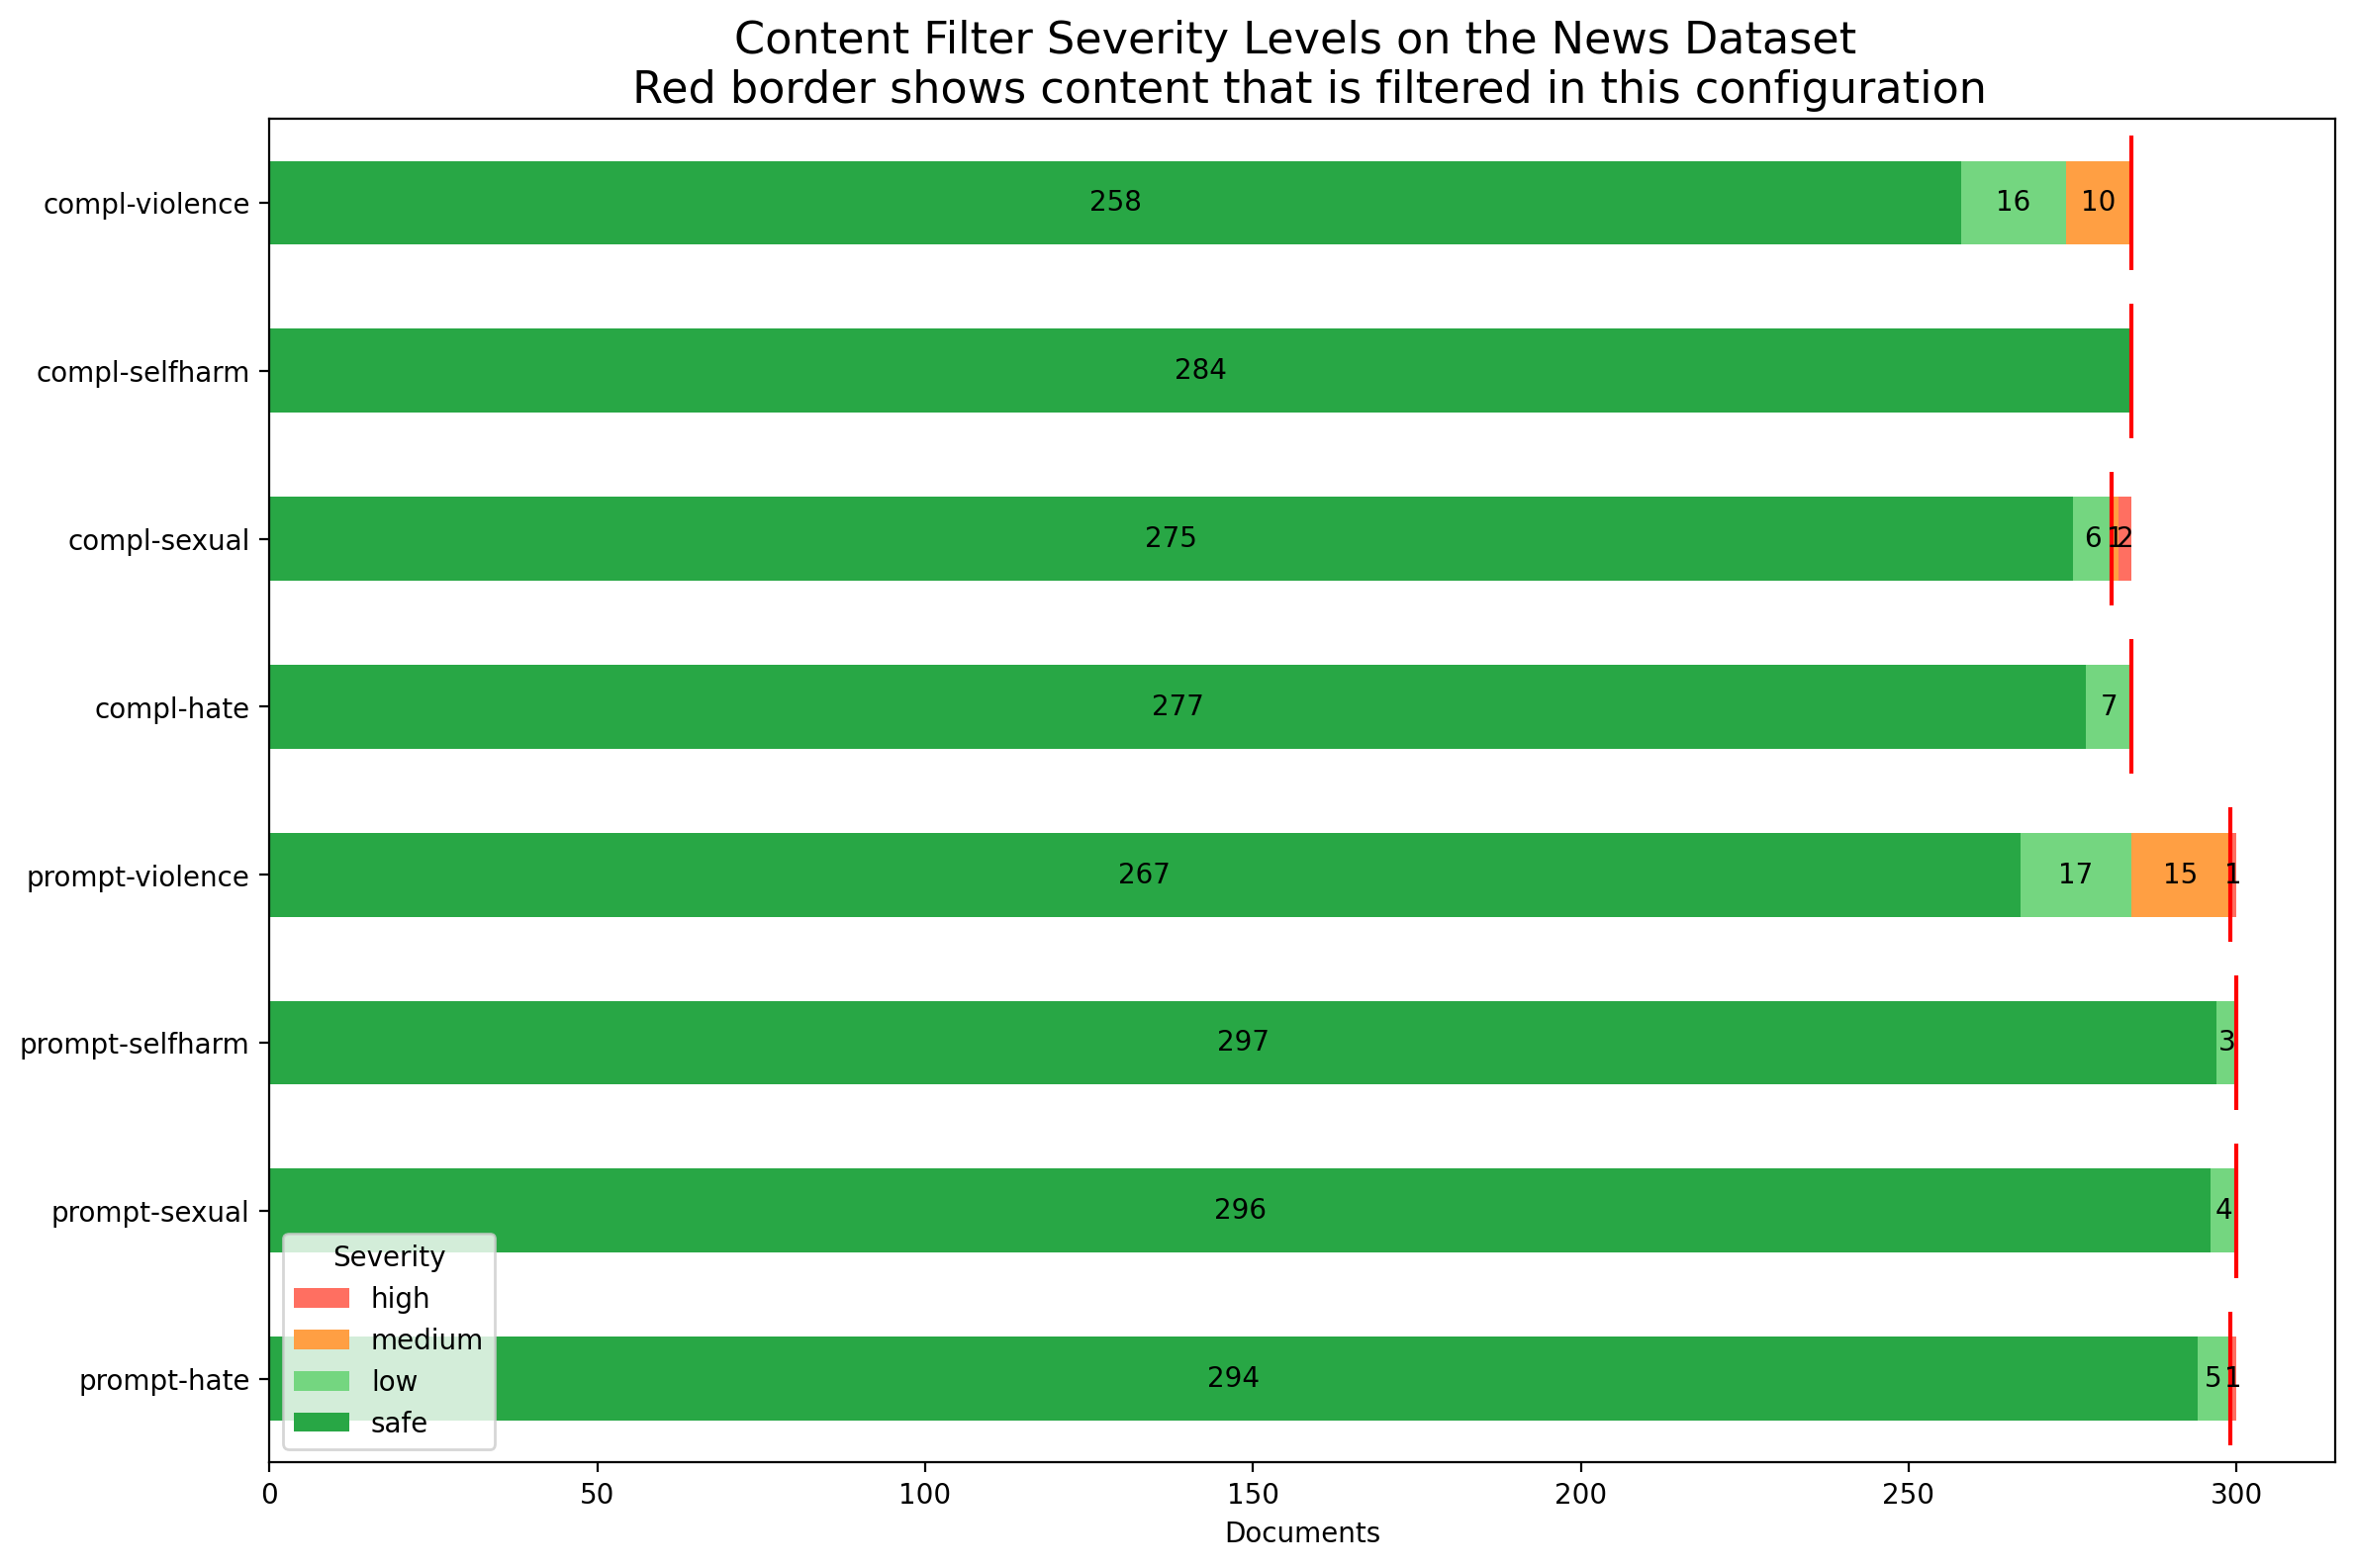

In [14]:
# Specify your configuration to review the impact:

adjusted_filter_threshold = {
    'prompt-hate' : 'medium',
    'prompt-sexual' : 'medium',
    'prompt-selfharm' : 'medium',
    'prompt-violence' : 'high',
    'compl-hate' : 'medium',
    'compl-sexual' : 'medium',
    'compl-selfharm' : 'medium',
    'compl-violence' : 'high',
}

show_statistics(value_counts_df, adjusted_filter_threshold)

## Adjusting the Content Filter in the Azure OpenAI Studio
Now that we have found our target settings, we are adjusting the Content Filter that is associated with the deployed model in the [Azure OpenAI Studio](https://oai.azure.com/contentFilter) accordingly.
The settings that we have identified above correspond with the configuration in the screenshot from the Azure OpenAI Studio.
![image-alt-text](./content-filter-news.png)


## Generate final Results

In [15]:
# Reload previous version
df_sample_final = pd.read_csv(annot_sample)

# Clear previously generated summaries and severity annotations
df_sample_final[severity_cols] = df_sample_final[severity_cols].apply(lambda x: pd.NA)
df_sample_final['summary'] = ''

In [16]:
# Generate final summaries for the whole dataframe. 
# NOTE that this operation incurs Azure OpenAI service charges.

df_sample_final = df_sample_final.apply(process_df_row, axis=1)

In [17]:
display(df_sample_final.head())

,article,tokens,summary,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
0,(CNN) -- A South Florida man killed his wife a...,531.0,A man in South Florida killed his wife and son...,safe,safe,safe,medium,safe,safe,low,medium
1,"By . Matt Chorley, Mailonline Political Editor...",816.0,Tourism bosses in Britain are using the birth ...,safe,safe,safe,safe,safe,safe,safe,safe
2,"Downton Abbey's famously grim butler, Mr Bates .",13.0,"Downton Abbey's character Mr. Bates, who is kn...",safe,safe,safe,safe,safe,safe,safe,safe
3,Schoolchildren were forced to evacuate a playg...,444.0,"A school in Watford, Hertfordshire had to evac...",safe,safe,safe,safe,safe,safe,safe,safe
4,Gender-neutral bathrooms will now be mandatory...,319.0,"Starting tomorrow, gender-neutral bathrooms wi...",safe,safe,safe,safe,safe,safe,safe,safe


In [18]:
# Save final results to file
final_sample = os.path.join(output_folder, 'sample-final-with-annotations.csv')
df_sample.to_csv(final_sample, index=False)